## Reference

- [Adversarial Neural Cryptography in TensorFlow](https://github.com/ankeshanand/neural-cryptography-tensorflow)
- [Learning to protect communications with adversarial neural cryptography](https://blog.acolyer.org/2017/02/10/learning-to-protect-communications-with-adversarial-neural-cryptography/)

In [1]:
import numpy as np
import tensorflow as tf

## Config and data

In [2]:
filters =[
    [4, 1, 2],
    [2, 2, 4],
    [1, 4, 4],
    [1, 4, 1]
]

msg_len = 32
key_len = 32
batch_size = 512
num_epochs = 100
num_steps = 500
learning_rate= 0.0008
verbose_epoch = 5

In [3]:
def gen_data(n, msg_len, key_len):
    return (np.random.randint(0, 2, size=(n, msg_len))*2 - 1), (np.random.randint(0, 2, size=(n, key_len))*2 - 1)

In [4]:
sample_msg, sample_key = gen_data(5, msg_len, key_len)
print(sample_msg, sample_msg.shape, '\n', sample_key, sample_key.shape)

[[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1 -1
  -1  1 -1  1 -1 -1  1 -1]
 [ 1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1  1  1 -1  1 -1
  -1 -1  1 -1 -1  1 -1 -1]
 [-1  1  1  1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1 -1 -1 -1
  -1  1 -1 -1  1  1  1  1]
 [ 1 -1 -1  1  1 -1 -1 -1 -1  1 -1  1  1 -1 -1 -1  1  1 -1 -1  1 -1 -1 -1
   1  1  1  1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1
  -1 -1 -1  1  1  1  1  1]] (5, 32) 
 [[-1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1  1  1  1  1  1  1  1  1 -1
  -1 -1 -1  1 -1 -1  1  1]
 [ 1 -1 -1  1 -1 -1  1 -1 -1  1  1  1 -1  1 -1 -1  1 -1  1  1  1  1  1  1
   1 -1 -1  1  1 -1 -1  1]
 [-1  1  1 -1  1  1  1  1  1  1 -1 -1  1  1 -1 -1  1 -1 -1  1  1  1 -1 -1
   1 -1 -1  1  1  1 -1 -1]
 [-1  1 -1  1 -1 -1  1 -1  1  1 -1  1  1  1  1 -1  1 -1  1  1  1  1 -1  1
  -1 -1 -1  1 -1  1  1 -1]
 [ 1 -1  1 -1  1  1  1  1 -1  1 -1  1 -1  1  1  1  1 -1 -1 -1 -1 -1  1 -1
  -1 -

## Model

- Alice : plain text + key => cipher text
- Bob : cipher text + key => plain text
- Eve : cipher text => plain text

In [5]:
# mix & transform architecture

def fc_layer(X, W, case=None):
    if case == "eve":
        h1 = tf.nn.sigmoid(tf.matmul(X, W[0]))
        h2 = tf.nn.sigmoid(tf.matmul(h1, W[1]))
        return tf.expand_dims(h2, axis=2)
    else:
        h = tf.nn.sigmoid(tf.matmul(X, W))
        return tf.expand_dims(h, axis=2)

def conv1d(X, filter_shape, stride, name="conv1d"):
    with tf.variable_scope(name):
        W = tf.get_variable('W', shape=filter_shape, initializer=tf.contrib.layers.xavier_initializer())
        conv = tf.nn.conv1d(X, W, stride, padding='SAME')
        return conv
    
def conv_layer(X, name):
    h0 = tf.nn.relu(conv1d(X, filters[0], stride=1, name=name+'_h0_conv'))
    h1 = tf.nn.relu(conv1d(h0, filters[1], stride=2, name=name+'_h1_conv'))
    h2 = tf.nn.relu(conv1d(h1, filters[2], stride=1, name=name+'_h2_conv'))
    h3 = tf.nn.relu(conv1d(h2, filters[3], stride=1, name=name+'_h3_conv'))
    return h3

In [6]:
in_msg = tf.placeholder(shape=(None, msg_len), dtype=tf.float32, name="in_msg")
in_key = tf.placeholder(shape=(None, key_len), dtype=tf.float32, name="in_key")

# Alice's Network
W_alice = tf.get_variable("W_alice", shape=[2*msg_len, 2*msg_len], initializer=tf.contrib.layers.xavier_initializer())
in_alice = tf.concat([in_msg, in_key], 1)
output_alice = tf.squeeze(conv_layer(fc_layer(in_alice, W_alice), "alice"))

# Bob's Network
W_bob = tf.get_variable("W_bob", shape=[2*msg_len, 2*msg_len], initializer=tf.contrib.layers.xavier_initializer())
in_bob = tf.concat([output_alice, in_key], 1)
output_bob = tf.squeeze(conv_layer(fc_layer(in_bob, W_bob), "bob"))

# Eve's Network
W1_eve = tf.get_variable("W_eve1", shape=[msg_len, 2*msg_len], initializer=tf.contrib.layers.xavier_initializer())
W2_eve = tf.get_variable("W_eve2", shape=[2*msg_len, 2*msg_len], initializer=tf.contrib.layers.xavier_initializer())
in_eve = output_alice
output_eve = tf.squeeze(conv_layer(fc_layer(in_eve, (W1_eve, W2_eve), "eve"), "eve"))

## Train

In [7]:
def train():
    # Loss Function
    decrypt_err_eve = tf.reduce_mean(tf.abs(in_msg - output_eve))
    decrypt_err_bob = tf.reduce_mean(tf.abs(in_msg - output_bob))
    loss_bob = decrypt_err_bob + (1. - decrypt_err_eve) ** 2.
    
    # Get traning variables corresponding to each network
    t_vars = tf.trainable_variables()
    alice_bob_vars = [var for var in t_vars if 'alice_' in var.name or 'bob_' in var.name]
    eve_vars = [var for var in t_vars if 'eve_' in var.name]
    
    # Optiminzer
    bob_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_bob, var_list=alice_bob_vars)
    eve_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(decrypt_err_eve, var_list=eve_vars)
    
    bob_losses = []
    eve_losses = []
    
    # Training
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        
        def train_step(network_name, num_steps, optimizer, decrypt_err):
            decrypt_error = 1.
            bs = batch_size
            # Train Eve for two mini_batches to give it a slight computational edge
            if network_name == 'eve':
                bs *= 2

            for i in range(num_steps):
                data_msg, data_key = gen_data(n=bs, msg_len=msg_len, key_len=key_len)

                if network_name == 'bob':
                    feed_dict = {in_msg: data_msg, in_key: data_key}
                    _, decrypt_err_output = sess.run([optimizer, decrypt_err], feed_dict=feed_dict)
                elif network_name == 'eve':
                    feed_dict = {in_msg: data_msg, in_key: data_key}
                    _, decrypt_err_output = sess.run([optimizer, decrypt_err], feed_dict=feed_dict)

                decrypt_error = min(decrypt_error, decrypt_err_output)
            return decrypt_error
        
        for i in range(num_epochs):    
            if i % verbose_epoch == 0:
                print('Training Alice and Bob, Epoch:', i + 1)
            bob_loss = train_step('bob', num_steps, bob_optimizer, decrypt_err_bob)
            bob_losses.append(bob_loss)

            if i % verbose_epoch == 0:
                print('Training Eve, Epoch:', i + 1)
            eve_loss = train_step('eve', num_steps, eve_optimizer, decrypt_err_eve)
            eve_losses.append(eve_loss)
            
    return bob_losses, eve_losses

In [8]:
bob_losses, eve_losses = train()

Training Alice and Bob, Epoch: 1
Training Eve, Epoch: 1
Training Alice and Bob, Epoch: 6
Training Eve, Epoch: 6
Training Alice and Bob, Epoch: 11
Training Eve, Epoch: 11
Training Alice and Bob, Epoch: 16
Training Eve, Epoch: 16
Training Alice and Bob, Epoch: 21
Training Eve, Epoch: 21
Training Alice and Bob, Epoch: 26
Training Eve, Epoch: 26
Training Alice and Bob, Epoch: 31
Training Eve, Epoch: 31
Training Alice and Bob, Epoch: 36
Training Eve, Epoch: 36
Training Alice and Bob, Epoch: 41
Training Eve, Epoch: 41
Training Alice and Bob, Epoch: 46
Training Eve, Epoch: 46
Training Alice and Bob, Epoch: 51
Training Eve, Epoch: 51
Training Alice and Bob, Epoch: 56
Training Eve, Epoch: 56
Training Alice and Bob, Epoch: 61
Training Eve, Epoch: 61
Training Alice and Bob, Epoch: 66
Training Eve, Epoch: 66
Training Alice and Bob, Epoch: 71
Training Eve, Epoch: 71
Training Alice and Bob, Epoch: 76
Training Eve, Epoch: 76
Training Alice and Bob, Epoch: 81
Training Eve, Epoch: 81
Training Alice and

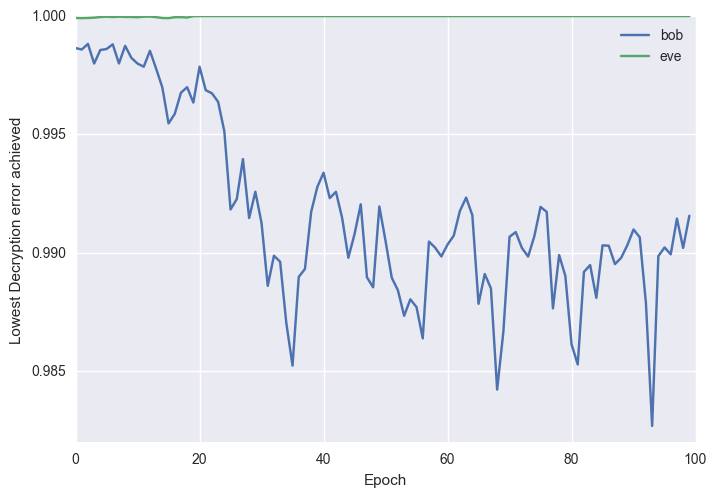

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

plt.plot(bob_losses)
plt.plot(eve_losses)
plt.legend(['bob', 'eve'])
plt.xlabel('Epoch')
plt.ylabel('Lowest Decryption error achieved')
plt.show()

### Paper's chart

![image](https://adriancolyer.files.wordpress.com/2017/02/adversarial-fig-2.jpeg?w=600)

출처: https://blog.acolyer.org/2017/02/10/learning-to-protect-communications-with-adversarial-neural-cryptography/